In [2]:
import json
import logging
import os
import random
import re
import sys
import time
import warnings
from numbers import Number
from typing import Callable, Dict, List, Literal, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pytest
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from datasets import Dataset
from fuzzywuzzy import fuzz

from postal.parser import parse_address
from scipy.spatial import distance
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
from sentence_transformers import InputExample, SentenceTransformer, SentencesDataset, SentenceTransformerTrainer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction, BinaryClassificationEvaluator
from sentence_transformers.model_card import SentenceTransformerModelCardData
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments
from tenacity import retry
from torch.utils.data import DataLoader
from torch.optim import RAdam
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, AutoModel, EarlyStoppingCallback, TrainingArguments, Trainer
from transformers.integrations import WandbCallback

from utils import (
    augment_gold_labels,
    compute_sbert_metrics,
    compute_classifier_metrics,
    format_dataset,
    gold_label_report,
    preprocess_logits_for_metrics,
    structured_encode_address,
    tokenize_function,
    to_dict,
    save_custom_model,
    load_custom_model,
)

In [3]:
RANDOM_SEED = 31337

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

In [4]:
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)

logger = logging.getLogger(__name__)

In [5]:
warnings.simplefilter('ignore', FutureWarning)

In [6]:
os.environ["WANDB_LOG_MODEL"] = "end"
os.environ["WANDB_WATCH"] = "gradients"
os.environ["WANDB_PROJECT"] = "libpostal-reborn"
os.environ["WANDB_DISABLED"] = "false"
os.environ["WANDB_IGNORE_GLOBS"] = ".env"

In [7]:
os.environ["WANDB_MODE"] = "online"

In [8]:
os.environ["HF_ENDPOINT"] = "https://huggingface.co/"

In [9]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [10]:
pd.set_option("display.max_rows", 40)
pd.set_option("display.max_columns", None)

In [11]:
# Check for CUDA or MPS availability and set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    logger.debug("Using Apple GPU acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    logger.debug("Using NVIDIA CUDA GPU acceleration")
else:
    device = "cpu"
    logger.debug("Using CPU for ML")

device

device(type='cuda')

In [12]:
# Login to wandb. Comment out if you already haven't via `wandb login` from a CLI
wandb.login()

wandb: Currently logged in as: rjurney. Use `wandb login --relogin` to force relogin


True

## Load our Datasets

In [14]:
gold_df = pd.read_csv("data/gold.csv")

In [15]:
# If you want to start from here and not run the data augmentation pipeline again...
augment_results_df = pd.read_parquet("data/training.6.parquet")

augment_results_df.head(20)

,Address1,Address2,Description,Label
0,"123 E Main St, Springfield, IL 62701","123 East Main Street, Springfield, Illinois 62701",Different directional prefix formats for same ...,1.0
1,"456 W Elm St, Boston, MA 02118","456 West Elm Street, Boston, Massachusetts 02118",Different directional prefix formats for same ...,1.0
2,"789 S Oak St, Denver, CO 80203","789 South Oak Street, Denver, Colorado 80203",Different directional prefix formats for same ...,1.0
3,"321 N Pine St, Seattle, WA 98101","321 North Pine Street, Seattle, Washington 98101",Different directional prefix formats for same ...,1.0
4,"654 E Maple St, Austin, TX 73301","654 East Maple Street, Austin, Texas 73301",Different directional prefix formats for same ...,1.0
5,"987 W Cedar St, San Francisco, CA 94102","987 West Cedar Street, San Francisco, Californ...",Different directional prefix formats for same ...,1.0
6,"246 S Birch St, New York, NY 10001","246 South Birch Street, New York, New York 10001",Different directional prefix formats for same ...,1.0
7,"135 N Cedar Ave, Chicago, IL 60601","135 North Cedar Avenue, Chicago, Illinois 60601",Different directional prefix formats for same ...,1.0
8,"864 E Pine Ave, Los Angeles, CA 90001","864 East Pine Avenue, Los Angeles, California ...",Different directional prefix formats for same ...,1.0
9,"753 W Spruce St, Houston, TX 77001","753 West Spruce Street, Houston, Texas 77001",Different directional prefix formats for same ...,1.0


### Fine-Tuning a Lowercase `SentenceTransformer`

Libposstal lowercases the address parts it produces, so we need to train a lowercase `SentenceTransformer` model. We can then load the weights of this pre-trained model as the embedding layers rather than the raw pre-trained embeddings we get from Huggingface Hub.

#### Lowercase our Dataset

In [16]:
lower_augment_results_df = augment_results_df.copy(deep=True)

lower_augment_results_df["Address1"] = lower_augment_results_df["Address1"].str.lower()
lower_augment_results_df["Address2"] = lower_augment_results_df["Address2"].str.lower()

In [17]:
train_df, tmp_df = train_test_split(lower_augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

train_dataset = Dataset.from_dict({
    "sentence1": train_df["Address1"].tolist(),
    "sentence2": train_df["Address2"].tolist(),
    "label": train_df["Label"].tolist(),
})

eval_dataset = Dataset.from_dict({
    "sentence1": eval_df["Address1"].tolist(),
    "sentence2": eval_df["Address2"].tolist(),
    "label": eval_df["Label"].tolist(),
})

test_dataset = Dataset.from_dict({
    "sentence1": test_df["Address1"].tolist(),
    "sentence2": test_df["Address2"].tolist(),
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Validation data: {len(eval_df):,}")
print(f"Test data        {len(eval_df):,}")

Training data:   8,024
Validation data: 1,003
Test data        1,003


In [18]:
SBERT_MODEL_LOWER = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
VARIANT = "lowercase"
LOWER_MODEL_SAVE_NAME = (SBERT_MODEL_LOWER + "-" + VARIANT).replace("/", "-")

# Make sure these match the values in the data augmentation notebook for accurate loggging and reporting
CLONES_PER_RUN = 100
RUNS_PER_EXAMPLE = 2

EPOCHS = 6
BATCH_SIZE = 32
PATIENCE = 2
LEARNING_RATE = .00005
DATASET_MULTIPLE = CLONES_PER_RUN * RUNS_PER_EXAMPLE
SBERT_LOWER_OUTPUT_FOLDER = f"data/fine-tuned-sbert-{LOWER_MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

In [19]:
# Initialize Weights & Biases
wandb.init(
    entity="rjurney",
    # set the wandb project where this run will be logged
    project="libpostal-reborn",
    # track hyperparameters and run metadata
    config={
        "variant": VARIANT,
        "dataset_multiple": DATASET_MULTIPLE,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE,
        "learning_rate": LEARNING_RATE,
        "sbert_model": SBERT_MODEL_LOWER,
        "model_save_name": LOWER_MODEL_SAVE_NAME,
        "sbert_output_folder": SBERT_LOWER_OUTPUT_FOLDER,
        "save_eval_steps": SAVE_EVAL_STEPS,
    },
    save_code=True,
)

In [20]:
sbert_model_lower = SentenceTransformer(
    SBERT_MODEL_LOWER,
    device=device,
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name=f"{SBERT_MODEL_LOWER}-address-matcher-{VARIANT}",
    ),
)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [21]:
# Initialize the evaluator
binary_acc_evaluator = BinaryClassificationEvaluator(
    sentences1=eval_dataset["sentence1"],
    sentences2=eval_dataset["sentence2"],
    labels=eval_dataset["label"],
    name=SBERT_MODEL_LOWER,
)
pd.DataFrame([binary_acc_evaluator(sbert_model_lower)])

,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_f1,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_precision,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_recall,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_ap,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_precision,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_recall,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_ap,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_precision,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_recall,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_ap,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_accuracy,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_accuracy_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_f1,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_f1_threshold,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_precision,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_recall,sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_ap
0,0.585244,0.686361,0.721595,0.517619,0.566215,0.994505,0.497195,0.568295,7.808429,0.715693,7.517566,0.55783,0.998168,0.609015,0.591226,64.763367,0.726547,70.368423,0.570533,1.0,0.488948,0.592223,4.35267,0.726787,4.35267,0.572029,0.996337,0.489592,0.592223,64.763367,0.726787,70.368423,0.572029,1.0,0.609015


In [22]:
# This will rapidly train the embedding model. MultipleNegativesRankingLoss did not work.
loss = losses.ContrastiveLoss(model=sbert_model_lower)

sbert_args = SentenceTransformerTrainingArguments(
    output_dir=SBERT_LOWER_OUTPUT_FOLDER,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    run_name=SBERT_MODEL_LOWER,
    load_best_model_at_end=True,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    learning_rate=LEARNING_RATE,
    logging_dir="./logs",
)

trainer = SentenceTransformerTrainer(
    model=sbert_model_lower,
    args=sbert_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=binary_acc_evaluator,
    compute_metrics=compute_sbert_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

trainer.evaluate()
trainer.train()

Step,Training Loss,Validation Loss,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine F1,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine F1 Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine Precision,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine Recall,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Cosine Ap,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot Accuracy,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot Accuracy Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot F1,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot F1 Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot Precision,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot Recall,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Dot Ap,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan F1,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan F1 Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan Precision,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan Recall,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Manhattan Ap,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean F1,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean F1 Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean Precision,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean Recall,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Euclidean Ap,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max Accuracy,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max Accuracy Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max F1,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max F1 Threshold,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max Precision,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max Recall,Sentence-transformers/paraphrase-multilingual-minilm-l12-v2 Max Ap
100,No log,0.020416,0.818544,0.873032,0.849359,0.810707,0.754986,0.970696,0.889106,0.782652,11.049636,0.807597,9.669561,0.735338,0.895604,0.877909,0.770688,31.891590,0.808652,31.891590,0.740854,0.890110,0.838255,0.768694,1.932054,0.807882,2.102785,0.732143,0.901099,0.838583,0.818544,31.891590,0.849359,31.891590,0.754986,0.970696,0.889106
200,No log,0.008793,0.937188,0.874723,0.942883,0.874723,0.933573,0.952381,0.981125,0.846461,11.930910,0.855805,11.643341,0.875479,0.836996,0.929795,0.895314,28.995537,0.904847,32.801125,0.887324,0.923077,0.959320,0.893320,1.879110,0.904425,2.212658,0.875000,0.935897,0.959590,0.937188,28.995537,0.942883,32.801125,0.933573,0.952381,0.981125
300,No log,0.005658,0.977069,0.895187,0.978841,0.890731,0.983364,0.974359,0.994758,0.883350,12.727057,0.895815,11.313406,0.871750,0.921245,0.954847,0.940179,32.478958,0.944853,32.478958,0.948339,0.941392,0.985463,0.940179,2.108047,0.944954,2.108047,0.946691,0.943223,0.985648,0.977069,32.478958,0.978841,32.478958,0.983364,0.974359,0.994758
400,No log,0.003839,0.986042,0.840904,0.987250,0.840904,0.981884,0.992674,0.997485,0.907278,11.968544,0.917772,11.968544,0.887179,0.950549,0.972336,0.962114,37.144295,0.965392,37.144295,0.960145,0.970696,0.993148,0.965105,2.361769,0.968037,2.361769,0.965392,0.970696,0.993274,0.

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=756, training_loss=0.007155877966729421, metrics={'train_runtime': 249.0548, 'train_samples_per_second': 193.307, 'train_steps_per_second': 3.035, 'total_flos': 0.0, 'train_loss': 0.007155877966729421, 'epoch': 6.0})

In [23]:
print(f"Best model checkpoint path: {trainer.state.best_model_checkpoint}")

Best model checkpoint path: data/fine-tuned-sbert-sentence-transformers-paraphrase-multilingual-MiniLM-L12-v2-lowercase/checkpoint-700


In [24]:
pd.DataFrame([trainer.evaluate()])

,eval_loss,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_f1,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_precision,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_recall,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_ap,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_precision,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_recall,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_manhattan_ap,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_precision,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_recall,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_euclidean_ap,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_accuracy,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_accuracy_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_f1,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_f1_threshold,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_precision,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_recall,eval_sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_max_ap,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.002222,0.992024,0.875542,0.992674,0.875542,0.992674,0.992674,0.998656,0.931206,11.310286,0.9391,11.310286,0.906303,0.974359,0.981899,0.967099,35.272957,0.969863,36.375,0.967213,0.972527,0.995215,0.969093,2.33225,0.971844,2.373715,0.963964,0.979853,0.995388,0.992024,35.272957,0.992674,36.375,0.992674,0.992674,0.998656,2.0418,491.235,7.836,6.0


### Save the Best Model

Because we used `load_best_model_at_end=True`, our model is now the best one we fine-tuned. Save it.

In [25]:
trainer.save_model(SBERT_LOWER_OUTPUT_FOLDER)

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

In [26]:
wandb.finish()

eval/loss,█▄▂▂▁▁▁▁▁
eval/runtime,█▂▄▂▂▁▂▂▂
eval/samples_per_second,▁▇▅▇▇█▇▇▇
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,▁▅▇██████
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,▁▇▇█▆▇▇▇▇
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,▁▆███████
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,▁▄▇██████
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,▁▆██▇▇███
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,▁▄▇██████
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,█▄▁▅█████
eval/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,▁▅▆▇█████


### Rewrite our Matchers for Lowercase Duty

Need two versions of these to compare the original with their new lowercase cousins.

In [27]:
def sbert_compare_lower(address1: str, address2: str) -> float:
    """sbert_compare - sentence encode each address into a fixed-length text embedding.
    Fixed-length means they can be compared with cosine similarity."""
    embedding1 = sbert_model_lower.encode(address1.lower())
    embedding2 = sbert_model_lower.encode(address2.lower())

    # Compute cosine similarity
    return 1 - distance.cosine(embedding1, embedding2)


def sbert_match_lower(row: pd.Series) -> pd.Series:
    """sbert_match - SentenceTransformer address matching, float iytoyt"""
    return sbert_compare_lower(row["Address1"], row["Address2"])


def sbert_compare_binary_lower(address1: str, address2: str, threshold: float = 0.5) -> Literal[0, 1]:
    """sbert_match - compare and return a binary match"""
    similarity = sbert_compare_lower(address1, address2)
    return 1 if similarity >= threshold else 0


def sbert_match_binary_lower(row: pd.Series, threshold: float = 0.5) -> pd.Series:
    """sbert_match_binary - SentenceTransformer address matching, binary output"""
    return sbert_compare_binary_lower(row["Address1"], row["Address2"], threshold=threshold)

### Evaluate ROC Curve to Determine Optimum Similarity Threshold

We need to evaluate the ROC Curve of the F1 score to see what it should be set to for our lowercase model too. Recall that the `sbert_match_lower` function has a `threshold: float = 0.5` argument.

#### Evaluate on our Augmented Test Dataset

First we'll evaluate the ROC curve on our augmented test dataset.

In [28]:
y_true = test_df["Label"]
y_scores = test_df.apply(sbert_match_lower, axis=1)

In [29]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.8714630209955745
Best F1 Score: 0.987535953978907
AUC-ROC: 0.9979978505751702


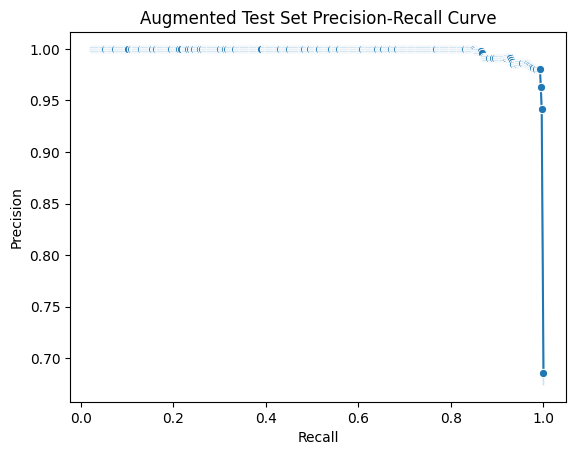

In [30]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Augmented Test Set Precision-Recall Curve')
plt.show()

### Plot a ROC Curve for our Gold Labeled Data

We need to see the ROC Curve for our gold labeled data as well. We care more about performance on this data.

In [31]:
y_true = gold_df["Label"]
y_scores = gold_df.apply(sbert_match_lower, axis=1)

In [32]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.8320894562185885
Best F1 Score: 0.8089887640449438
AUC-ROC: 0.7888501742160279


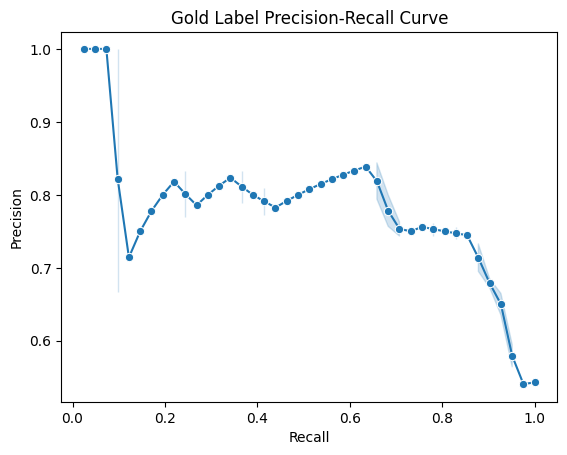

In [33]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gold Label Precision-Recall Curve')
plt.show()

In [34]:
sbert_compare_lower(
    "nw 5th ave",
    "northwest 5th avenue"
)

0.9319450597090926

In [35]:
sbert_compare_lower(
    "101 market square, seattle, wa 98039",
    "101 davis ct., seattle, wa 98039"
)

0.6700546782579614